<a href="https://colab.research.google.com/github/Farouk96/Dogs_classification_deeplearning/blob/main/P8_01_documentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#IMPORT REQUIRED LIBRARIEs
from time import time
import numpy as np
import pandas as pd
import os
from re import search
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D,Dropout

In [3]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


#Data preparation

In [4]:
#IMAGE PATH & DATAFRAME:
TRAIN_PATH = "/content/drive/MyDrive/ P8_kaggle_competition/train_images"
train_df = pd.read_csv("/content/drive/MyDrive/ P8_kaggle_competition/train.csv",sep=',')
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [5]:
from os import listdir
from os.path import isfile, join

monRepertoire='/content/drive/MyDrive/ P8_kaggle_competition/train_images'
fichiers = [f for f in listdir(monRepertoire) if isfile(join(monRepertoire, f))]
fichiers

['c04632b533bba33d.jpg',
 'c03e65db32f086cd.jpg',
 'c0377614f870c35f.jpg',
 'c05a3720fd610edf.jpg',
 'c0702f17c4f8fb45.jpg',
 'c06d02d4ca4af5df.jpg',
 'c06c7a60b360b77e.jpg',
 'c08552de599f1c2f.jpg',
 'c08364e6716477fa.jpg',
 'c0816a962dceb76b.jpg',
 'c0853d6535f2d43e.jpg',
 'c08eb5c5b7953c98.jpg',
 'c0883b8e6e2ddf29.jpg',
 'c08e2b86b5bf70a3.jpg',
 'c09798cb9eb16639.jpg',
 'c09f21a433bf3758.jpg',
 'c09e35c7d027fa16.jpg',
 'c09927d183363cdf.jpg',
 'c0983fc02e27facb.jpg',
 'c09a3f8d684f1579.jpg',
 'c0a42dfd195dd331.jpg',
 'c0c063eb2afc3ab5.jpg',
 'c0c2202b0f7f7fe4.jpg',
 'c0bc431f5396b0f5.jpg',
 'c0bd68dad79507a2.jpg',
 'c0c73614ce4ee4ed.jpg',
 'c0cb3f1b38f8e0d4.jpg',
 'c0c8679f29e519bc.jpg',
 'c0cf8b9899d591b3.jpg',
 'c0c66a37fdf58061.jpg',
 'c0df29ce91d73950.jpg',
 'c0e027301fd757ad.jpg',
 'c0d91da6b3b891cd.jpg',
 'c0df0336b4707e65.jpg',
 'c0e00e1cff8f429f.jpg',
 'c0e6e21b32cde8f4.jpg',
 'c0e1616f4d439b9b.jpg',
 'c0e18cf07d1b2de9.jpg',
 'c0f1155cba5c13fc.jpg',
 'c0ef90ea018ffb1c.jpg',


In [6]:
idx_list=[]
for i in train_df['image']:
  if i not in fichiers:
    dt= train_df[train_df['image']==i]
    train_df.drop(dt.index,axis=0,inplace=True)

In [7]:
train_df.shape

(6227, 2)

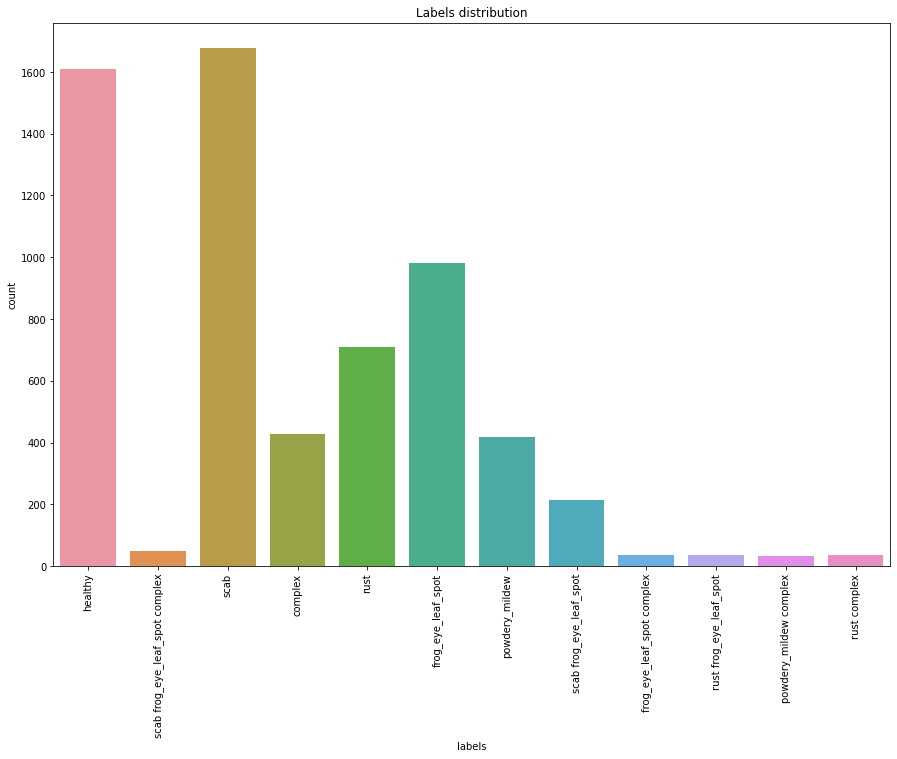

In [8]:
#Labels distribution
plt.figure(figsize=(15,10))
sns.countplot(data=train_df,x='labels')
plt.xticks(rotation=90)
plt.title('Labels distribution')
plt.show()

In [9]:
print("Number of unique labels: ",len(train_df['labels'].unique()))

Number of unique labels:  12


In [10]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)

In [11]:
HEIGHT = 124
WIDTH=124
SEED = 143
BATCH_SIZE=32
train_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False)

val_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

Found 4982 non-validated image filenames belonging to 12 classes.
Found 1245 non-validated image filenames belonging to 12 classes.


#CNN from scratch

In [11]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(HEIGHT,WIDTH,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12,activation='sigmoid'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [12]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [13]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [14]:
t0 = time()

epochs = 60

model_history=model.fit(train_ds,validation_data=val_ds,
                                 epochs= epochs,
                                 steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/60
38/38 [==============================] - ETA: 0s - loss: 1.9678 - f1_score: 0.0715
Epoch 00001: val_f1_score improved from -inf to 0.02913, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5
38/38 [==============================] - 230s 6s/step - loss: 1.9678 - f1_score: 0.0715 - val_loss: 1.8913 - val_f1_score: 0.0291
Epoch 2/60
38/38 [==============================] - ETA: 0s - loss: 1.8851 - f1_score: 0.0569
Epoch 00002: val_f1_score improved from 0.02913 to 0.03327, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5
38/38 [==============================] - 206s 5s/step - loss: 1.8851 - f1_score: 0.0569 - val_loss: 1.8740 - val_f1_score: 0.0333
Epoch 3/60
38/38 [==============================] - ETA: 0s - loss: 1.8414 - f1_score: 0.0686
Epoch 00003: val_f1_score improved from 0.03327 to 0.10293, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5
38/38 [==============================] - 

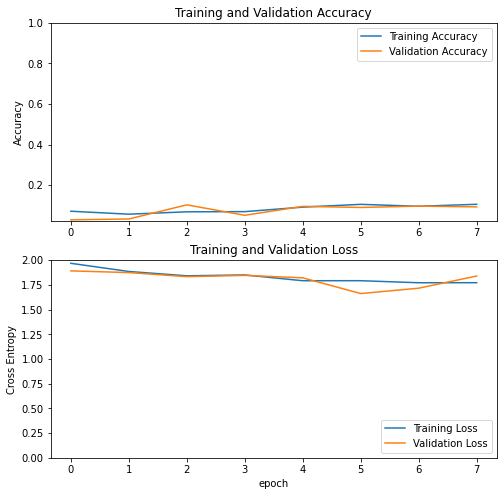

In [16]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Transfer learning with inceptionV3

In [27]:
from  tensorflow.keras.applications import InceptionV3

In [51]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  InceptionV3(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

In [28]:
base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 320)               655680    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3852      
                                                                 
Total params: 22,462,316
Trainable params: 659,532
Non-trainable params: 21,802,784
____________________________________

In [20]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [21]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [22]:
t0 = time()

epochs = 20

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 2.7091 - f1_score: 0.1147
Epoch 00001: val_f1_score improved from -inf to 0.09782, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
38/38 [==============================] - 214s 6s/step - loss: 2.7091 - f1_score: 0.1147 - val_loss: 1.8296 - val_f1_score: 0.0978
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 1.7725 - f1_score: 0.1574
Epoch 00002: val_f1_score improved from 0.09782 to 0.16469, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
38/38 [==============================] - 204s 5s/step - loss: 1.7725 - f1_score: 0.1574 - val_loss: 1.7856 - val_f1_score: 0.1647
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 1.6788 - f1_score: 0.1806
Epoch 00003: val_f1_score improved from 0.16469 to 0.18196, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
38/38

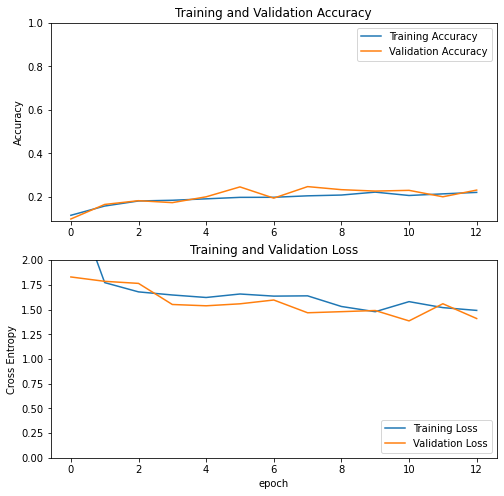

In [23]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine_tunning

In [24]:
base_model.trainable = True

In [25]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [26]:
fine_tune_at = 200

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001/10),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [31]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [32]:
t0 = time()

fine_tune_epochs = 40
total_epochs =  epochs + fine_tune_epochs

model_history_fine = model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= total_epochs,
                         initial_epoch=model_history.epoch[-1],
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 13/60
38/38 [==============================] - ETA: 0s - loss: 1.2564 - f1_score: 0.2755
Epoch 00013: val_f1_score improved from -inf to 0.26524, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5
38/38 [==============================] - 215s 6s/step - loss: 1.2564 - f1_score: 0.2755 - val_loss: 1.3784 - val_f1_score: 0.2652
Epoch 14/60
38/38 [==============================] - ETA: 0s - loss: 1.1902 - f1_score: 0.2919
Epoch 00014: val_f1_score improved from 0.26524 to 0.27950, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5
38/38 [==============================] - 208s 6s/step - loss: 1.1902 - f1_score: 0.2919 - val_loss: 1.2315 - val_f1_score: 0.2795
Epoch 15/60
38/38 [==============================] - ETA: 0s - loss: 1.1716 - f1_score: 0.3164
Epoch 00015: val_f1_score improved from 0.27950 to 0.29811, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5
38/38 [=======

In [33]:
acc += model_history_fine.history['f1_score']
val_acc += model_history_fine.history['val_f1_score']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

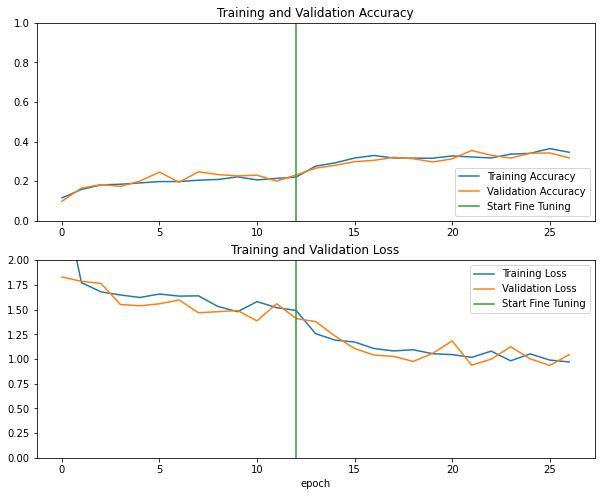

In [34]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([model_history.epoch[-1],model_history.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([model_history.epoch[-1],model_history.epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Transfer learning with MobileNetV2

In [35]:
from  tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [36]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  MobileNetV2(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [37]:
base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 320)               409920    
                                                                 
 dropout_2 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                3852      
                                                                 
Total params: 2,671,756
Trainable params: 413,772
Non-

In [38]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [39]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [40]:
t0 = time()

epochs = 20

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.9650 - f1_score: 0.1679
Epoch 00001: val_f1_score improved from -inf to 0.24332, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 211s 6s/step - loss: 1.9650 - f1_score: 0.1679 - val_loss: 1.5585 - val_f1_score: 0.2433
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 1.5900 - f1_score: 0.2114
Epoch 00002: val_f1_score did not improve from 0.24332
38/38 [==============================] - 199s 5s/step - loss: 1.5900 - f1_score: 0.2114 - val_loss: 1.4273 - val_f1_score: 0.2422
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 1.4536 - f1_score: 0.2416
Epoch 00003: val_f1_score improved from 0.24332 to 0.26448, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5
38/38 [==============================] - 201s 5s/step - loss: 1.4536 - f1_score: 0.2416 - val_loss: 1.3100 - val_f1_score: 0.2645
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 1.3697 - f1_score: 0.2572
Epoch 00004: val_f1_score did not improve from 0.26448
38/38 [==============================] - 200s 5s/step - loss: 1.36

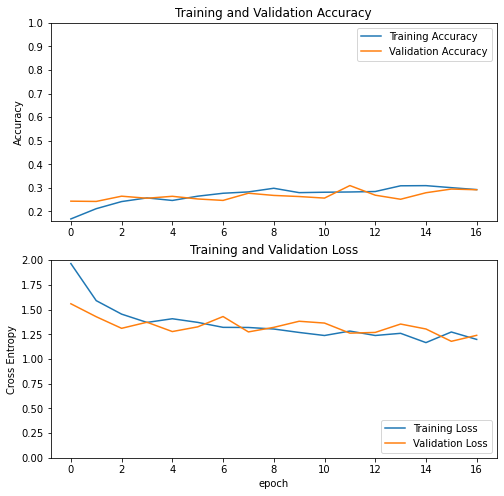

In [41]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine-tunning

In [42]:
base_model.trainable = True

In [43]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [44]:
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [45]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [46]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [47]:
t0 = time()

fine_tune_epochs = 40
total_epochs =  20 + fine_tune_epochs

model_history_fine = model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= total_epochs,
                         initial_epoch=19, #model_history.epoch[-1],
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 20/60
38/38 [==============================] - ETA: 0s - loss: 1.5301 - f1_score: 0.2378
Epoch 00020: val_f1_score improved from -inf to 0.07942, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 211s 5s/step - loss: 1.5301 - f1_score: 0.2378 - val_loss: 9.6702 - val_f1_score: 0.0794
Epoch 21/60
38/38 [==============================] - ETA: 0s - loss: 1.2392 - f1_score: 0.2775
Epoch 00021: val_f1_score improved from 0.07942 to 0.09944, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5
38/38 [==============================] - 202s 5s/step - loss: 1.2392 - f1_score: 0.2775 - val_loss: 9.9668 - val_f1_score: 0.0994
Epoch 22/60
38/38 [==============================] - ETA: 0s - loss: 1.1670 - f1_score: 0.3047
Epoch 00022: val_f1_score did not improve from 0.09944
38/38 [==============================] - 201s 5s/step - loss: 1.1670 - f1_score: 0.3047 - val_loss: 10.1744 - val_f1_score: 0.0830
Epoch 23/60
38/38 [==============================] - ETA: 0s - loss: 1.1101 - f1_score: 0.3169
Epoch 00023: val_f1_score improved from 0.09944 to 0.19587, saving model to /content/drive/MyDrive/ P8_kaggle_competition

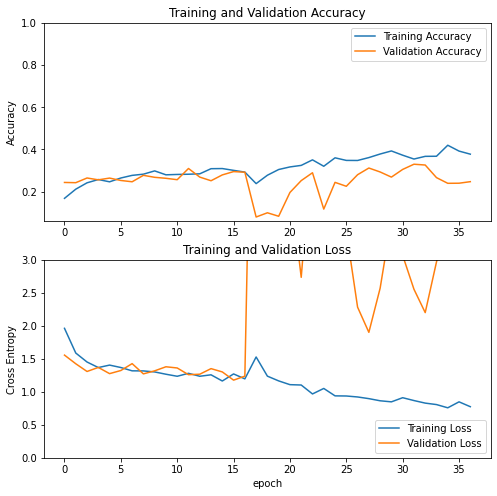

In [48]:
acc += model_history_fine.history['f1_score']
val_acc += model_history_fine.history['val_f1_score']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Improove performances

In [12]:
from  tensorflow.keras.applications import InceptionV3

In [13]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  InceptionV3(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [19]:
base_model.trainable = True
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
#odel.add(tf.keras.layers.Dense(320, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 12)                24588     
                                                                 
Total params: 21,827,372
Trainable params: 21,792,940
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [21]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [22]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001/10),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [37]:
#drop_out=0.5
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/40
38/38 [==============================] - ETA: 0s - loss: 2.2551 - f1_score: 0.0928 
Epoch 00001: val_f1_score improved from -inf to 0.09026, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==============================] - 571s 15s/step - loss: 2.2551 - f1_score: 0.0928 - val_loss: 2.2619 - val_f1_score: 0.0903
Epoch 2/40
38/38 [==============================] - ETA: 0s - loss: 1.8811 - f1_score: 0.1294 
Epoch 00002: val_f1_score improved from 0.09026 to 0.17391, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==============================] - 512s 13s/step - loss: 1.8811 - f1_score: 0.1294 - val_loss: 1.9414 - val_f1_score: 0.1739
Epoch 3/40
38/38 [==============================] - ETA: 0s - loss: 1.7682 - f1_score: 0.1682
Epoch 00003: val_f1_score improved from 0.17391 to 0.19806, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==================

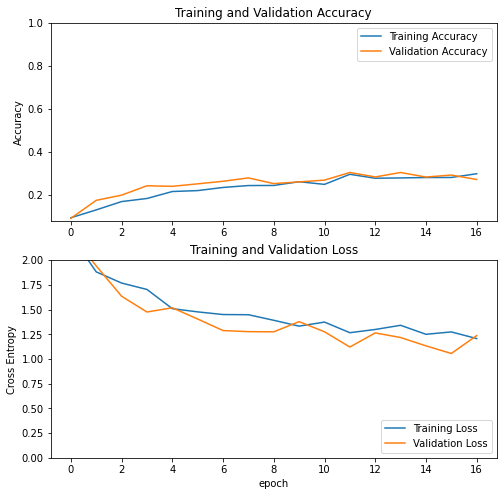

In [38]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
#No drop out
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/40
38/38 [==============================] - ETA: 0s - loss: 1.3520 - f1_score: 0.2468
Epoch 00001: val_f1_score improved from -inf to 0.26561, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==============================] - 350s 9s/step - loss: 1.3520 - f1_score: 0.2468 - val_loss: 1.1936 - val_f1_score: 0.2656
Epoch 2/40
38/38 [==============================] - ETA: 0s - loss: 1.3039 - f1_score: 0.2612
Epoch 00002: val_f1_score did not improve from 0.26561
38/38 [==============================] - 340s 9s/step - loss: 1.3039 - f1_score: 0.2612 - val_loss: 1.3050 - val_f1_score: 0.2623
Epoch 3/40
38/38 [==============================] - ETA: 0s - loss: 1.2288 - f1_score: 0.2743
Epoch 00003: val_f1_score did not improve from 0.26561
38/38 [==============================] - 340s 9s/step - loss: 1.2288 - f1_score: 0.2743 - val_loss: 1.2977 - val_f1_score: 0.2456
Epoch 4/40
38/38 [==============================] - ETA: 0s - loss: 1.1681 - 

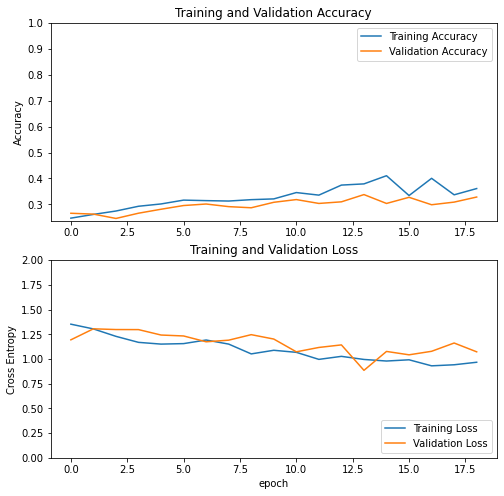

In [47]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
#No dense layer no dropout with flaten
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/40
38/38 [==============================] - ETA: 0s - loss: 2.0944 - f1_score: 0.1139 
Epoch 00001: val_f1_score improved from -inf to 0.17948, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==============================] - 745s 19s/step - loss: 2.0944 - f1_score: 0.1139 - val_loss: 2.0004 - val_f1_score: 0.1795
Epoch 2/40
38/38 [==============================] - ETA: 0s - loss: 1.6862 - f1_score: 0.1799 
Epoch 00002: val_f1_score improved from 0.17948 to 0.18350, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==============================] - 603s 16s/step - loss: 1.6862 - f1_score: 0.1799 - val_loss: 1.7848 - val_f1_score: 0.1835
Epoch 3/40
38/38 [==============================] - ETA: 0s - loss: 1.4787 - f1_score: 0.2132 
Epoch 00003: val_f1_score improved from 0.18350 to 0.21716, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [=================

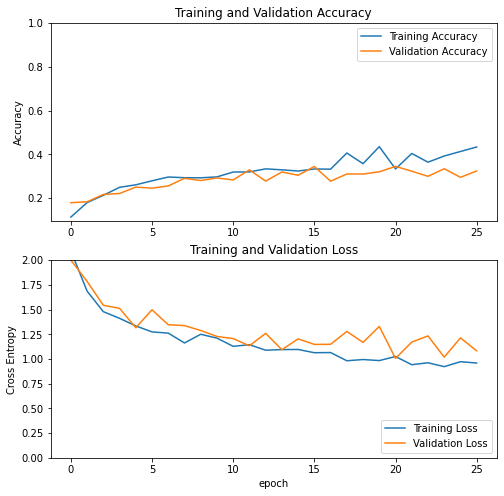

In [18]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/40
38/38 [==============================] - ETA: 0s - loss: 2.1859 - f1_score: 0.1109 
Epoch 00001: val_f1_score improved from -inf to 0.11692, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==============================] - 577s 15s/step - loss: 2.1859 - f1_score: 0.1109 - val_loss: 2.2601 - val_f1_score: 0.1169
Epoch 2/40
38/38 [==============================] - ETA: 0s - loss: 1.7081 - f1_score: 0.1693
Epoch 00002: val_f1_score improved from 0.11692 to 0.17839, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [==============================] - 468s 12s/step - loss: 1.7081 - f1_score: 0.1693 - val_loss: 1.7600 - val_f1_score: 0.1784
Epoch 3/40
38/38 [==============================] - ETA: 0s - loss: 1.4855 - f1_score: 0.2197
Epoch 00003: val_f1_score improved from 0.17839 to 0.22990, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5
38/38 [===================

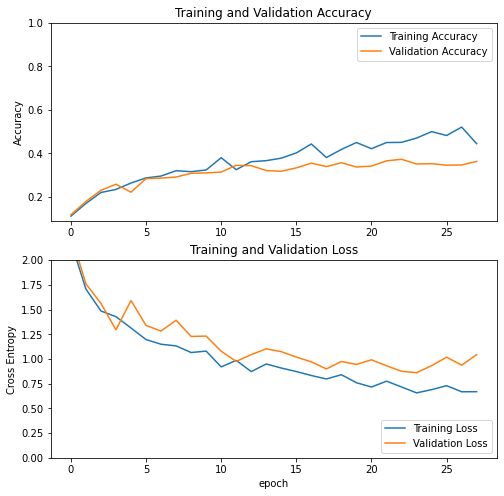

In [25]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Evaluation performance

##CNN from scratch

In [26]:
model.load_weights("/content/drive/MyDrive/ P8_kaggle_competition/best_model_cnn.h5")
loss, accuracy = model.evaluate(val_ds)
print('Valid accuracy :', round(accuracy, 3))
print('Valid loss :', round(loss, 3))

ValueError: ignored

##InceptionV3

In [ ]:
model.load_weights("/content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5")
loss, accuracy = model.evaluate(val_ds)
print('Valid accuracy :', round(accuracy, 3))
print('Valid loss :', round(loss, 3))

##MobileNetV2

In [ ]:
model.load_weights("/content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5")
loss, accuracy = model.evaluate(val_ds)
print('Valid accuracy :', round(accuracy, 3))
print('Valid loss :', round(loss, 3))

#SUBMISSION OF FILE

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ P8_kaggle_competition/sample_submission.csv')
submission.head()

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)
INPUT_SIZE = (124,124,3)
test_generator =  test_datagen.flow_from_dataframe(
    submission,
    directory="/content/drive/MyDrive/ P8_kaggle_competition/test_images",
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
) 

In [ ]:
preds = model.predict(test_generator)
print(preds)

In [ ]:
train_ds.class_indices

In [ ]:
def get_key(val):
    for key, value in train_ds.class_indices.items():
        if val == value:
            return key

In [ ]:
def get_preds_to_labels(preds):
    pred_lists = []
    for pred in preds:
        pred_list = []
        health = (pred>=0.4)
        
        # get healthy
        if health.sum()==0:
            label = 'healthy'
            pred_list.append(label)
            
        elif pred[2]>=0.5:
            label = 'healthy'
            pred_list.append(label)
            
        # get eles label
        else:
            for j, sub in enumerate(pred):
                if sub>=0.28:
                    label = get_key(j)
                    pred_list.append(label)
                               
        pred_lists.append(' '.join(pred_list))
    return pred_lists

In [ ]:
preds_list = get_preds_to_labels(preds)

In [ ]:
#submission['labels'] = preds_list
submission.head()

In [ ]:
submission.to_csv('/content/drive/MyDrive/ P8_kaggle_competition/submission.csv', index=False)